In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import os
import glob
import shutil
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "flowers"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


daisy
dandelion
rose
sunflower
tulip



In [2]:
# Check for the directory and if it doesn't exist, make one.
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
    
# make the models sub-directory
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [9]:
# Define some paths
input_path = Path('./')
flowers_path = input_path / 'flowers'
print(flowers_path)

flowers


In [10]:
# Each species of flower is contained in a separate folder . Get all the sub directories
flower_types = os.listdir(flowers_path)
print("Types of flowers found: ", len(flower_types))
print("Categories of flowers: ", flower_types)

Types of flowers found:  5
Categories of flowers:  ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [13]:
# In order to keep track of my data details or in order to do some EDA, I always try to 
# get the information in a dataframe. After all, pandas to the rescue!!

# A list that is going to contain tuples: (species of the flower, corresponding image path)
flowers = []

for species in flower_types:
    # Get all the file names
    all_flowers = os.listdir(flowers_path / species)
    # Add them to the list
    for flower in all_flowers:
        flowers.append((species, str(flowers_path /species) + '\\' + flower))

# Build a dataframe        
flowers = pd.DataFrame(data=flowers, columns=['category', 'image'], index=None)
flowers.head()

,category,image
0,daisy,flowers\daisy\100080576_f52e8ee070_n.jpg
1,daisy,flowers\daisy\10140303196_b88d3d6cec.jpg
2,daisy,flowers\daisy\10172379554_b296050f82_n.jpg
3,daisy,flowers\daisy\10172567486_2748826a8b.jpg
4,daisy,flowers\daisy\10172636503_21bededa75_n.jpg


In [14]:
# Let's check how many samples for each category are present
print("Total number of flowers in the dataset: ", len(flowers))
fl_count = flowers['category'].value_counts()
print("Flowers in each category: ")
print(fl_count)

Total number of flowers in the dataset:  4326
Flowers in each category: 
dandelion    1055
tulip         984
rose          784
daisy         769
sunflower     734
Name: category, dtype: int64


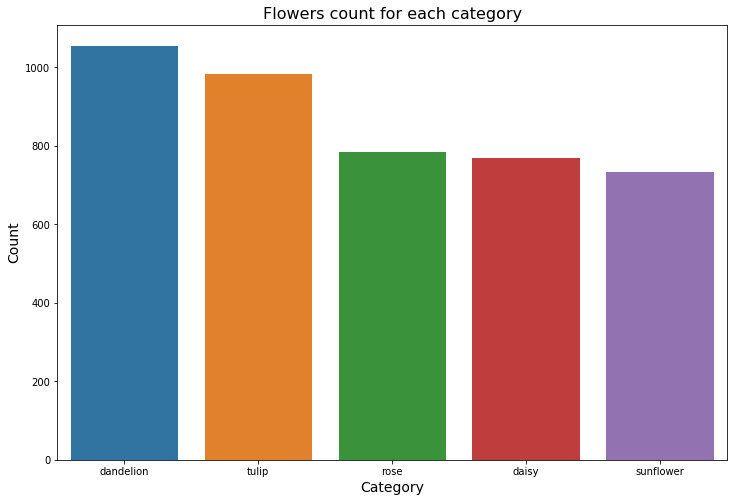

In [15]:
# Let's do some visualization too
plt.figure(figsize=(12,8))
sns.barplot(x=fl_count.index, y=fl_count.values)
plt.title("Flowers count for each category", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

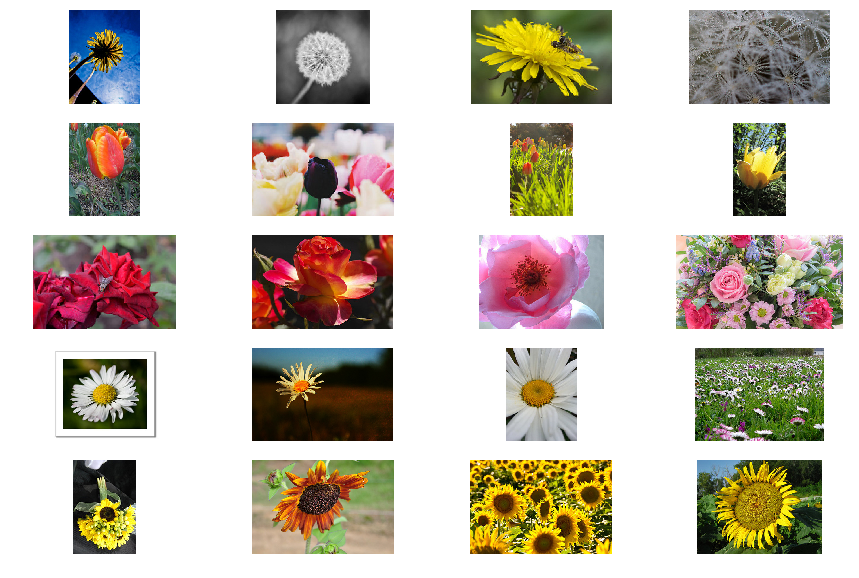

In [16]:
# Let's visualize flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].sample(4).values
    for sample in samples:
        random_samples.append(sample)



# Plot the samples
f, ax = plt.subplots(5,4, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//4, i%4].imshow(mimg.imread(random_samples[i]))
    ax[i//4, i%4].axis('off')
plt.show()    

In [17]:
# Make a parent directory `data` and two sub directories `train` and `valid`

%mkdir -p data/train
%mkdir -p data/valid

# Inside the train and validation sub=directories, make sub-directories for each catgeory
%cd data
%mkdir -p train/daisy
%mkdir -p train/tulip
%mkdir -p train/sunflower
%mkdir -p train/rose
%mkdir -p train/dandelion

%mkdir -p valid/daisy
%mkdir -p valid/tulip
%mkdir -p valid/sunflower
%mkdir -p valid/rose
%mkdir -p valid/dandelion

%cd ..

The syntax of the command is incorrect.


C:\Users\VKV\exp\github\mlfoundation\ml\mladvanced\Project\Capstone\data


The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.


C:\Users\VKV\exp\github\mlfoundation\ml\mladvanced\Project\Capstone


The syntax of the command is incorrect.


In [18]:
print(flowers)
for category in fl_count.index:
    samples = flowers['image'][flowers['category'] == category].values
    perm = np.random.permutation(samples)
    # Copy first 30 samples to the validation directory and rest to the train directory
    for i in range(30):
        print(perm[i])
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/valid/' + str(category) + '/'+ name)
    for i in range(31,len(perm)):
        name = perm[i].split('/')[-1]
        shutil.copyfile(perm[i],'./data/train/' + str(category) + '/' + name)

     category                                       image
0       daisy    flowers\daisy\100080576_f52e8ee070_n.jpg
1       daisy    flowers\daisy\10140303196_b88d3d6cec.jpg
2       daisy  flowers\daisy\10172379554_b296050f82_n.jpg
3       daisy    flowers\daisy\10172567486_2748826a8b.jpg
4       daisy  flowers\daisy\10172636503_21bededa75_n.jpg
5       daisy      flowers\daisy\102841525_bd6628ae3c.jpg
6       daisy  flowers\daisy\10300722094_28fa978807_n.jpg
7       daisy     flowers\daisy\1031799732_e7f4008c03.jpg
8       daisy  flowers\daisy\10391248763_1d16681106_n.jpg
9       daisy  flowers\daisy\10437754174_22ec990b77_m.jpg
10      daisy  flowers\daisy\10437770546_8bb6f7bdd3_m.jpg
11      daisy    flowers\daisy\10437929963_bc13eebe0c.jpg
12      daisy    flowers\daisy\10466290366_cc72e33532.jpg
13      daisy    flowers\daisy\10466558316_a7198b87e2.jpg
14      daisy    flowers\daisy\10555749515_13a12a026e.jpg
15      daisy    flowers\daisy\10555815624_dc211569b0.jpg
16      daisy 

FileNotFoundError: [Errno 2] No such file or directory: './data/valid/dandelion/flowers\\dandelion\\17175932454_c052e205c1_n.jpg'